## Movement definition

#### imports

In [89]:
import numpy as np
import pygame
from typing import Tuple

def normalize_radians(radians):
    normalized_radians = radians % (2 * np.pi)  
    if normalized_radians > np.pi:
        normalized_radians -= 2 * np.pi
    return normalized_radians

#### constants

In [90]:
WIDTH, HEIGHT = 800, 600
PLAYER_WIDTH = 50
PLAYER_HEIGHT = 10
PLAYER_SPEED = 5
WHITE = (255, 255, 255)
RED = (255, 0, 0)
STARTINGPOSITION = (WIDTH // 2,HEIGHT // 2)
DOTPERMETER = 26


#### car definition

Using kinematic bike model  
with positioniong the reference point on the center of gravity  
  
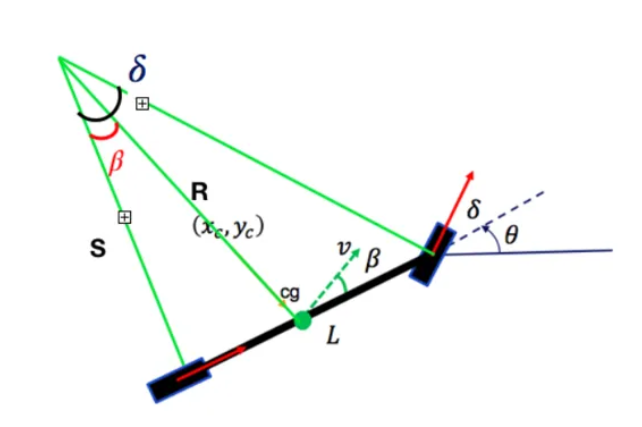

In [91]:
class Car:
    def __init__(self, maxSteeringAngle : float, position : Tuple[float, float] , maxSpeed : float, headingAngle : float, length : float):
        """ angles in radians """
        self.__maxSteeringAngle = maxSteeringAngle
        """in radian"""
        self.__position = position
        self.__maxSpeed = maxSpeed
        self.__headingAngle = headingAngle
        """theta, in radian"""

        
        self.__steeringRate = 0

        self.__steeringAngle = 0.0
        """gamma, in radian"""
        self.__length = length
        self.__speed = 0

    def get_position(self) -> Tuple[float, float]:
        return self.__position
    
    def set_position(self, position : Tuple[float, float]):
        self.__position = position

    def set_speed_rate(self, rate : float):
        """between 1 (max speed forward) and -1 (max speed backward)"""
        self.__speed = self.__maxSpeed * rate

    def get_speed(self):
        return self.__speed

    def get_heading_angle(self):
        """in radian"""
        return self.__headingAngle
    
    def get_max_steering_angle(self):
        """in radian"""
        return self.__maxSteeringAngle

    def set_steering_rate(self, rate : float):
        """between 1 (fully left) and -1 (fully right)"""
        self.__steeringAngle = self.__maxSteeringAngle * rate
        self.__steeringRate = rate

    def get_steering_rate(self):
        return self.__steeringRate

    def get_steering_angle(self):
        """in radian"""
        return self.__steeringAngle
    
    def get_car_length(self):
        return self.__length

    def travel(self, dt : float):
        beta = np.arctan(self.__length/2 * np.tan(self.__steeringAngle) / self.__length)
        posUpdate = (np.cos(beta+self.__headingAngle),np.sin(beta+self.__headingAngle))
        self.__position = np.add(self.__position, np.multiply((posUpdate[0], -posUpdate[1]), self.__speed * dt * DOTPERMETER))
        self.__headingAngle = normalize_radians(self.__headingAngle + (self.__speed*np.tan(self.__steeringAngle) *np.cos(beta) / self.__length)*dt)


#instantiation
car = Car(maxSteeringAngle=np.deg2rad(40),
          position=STARTINGPOSITION,
          maxSpeed=4.17, #15 km/h
          headingAngle=0.0,
          length= 5) #5 meters long

#### self driving

follows cursor
instead of 

In [92]:
def findSteeringRate(car : Car, desiredPosition : Tuple[float, float], epsilon):
    headingAngle = car.get_heading_angle()
    maxSteeringAngle = car.get_max_steering_angle()
    carPosition = car.get_position()
    headingDir = (np.cos(headingAngle), -np.sin(headingAngle))
    frontBumperPos = np.add(carPosition, np.multiply(car.get_car_length()/2*DOTPERMETER, headingDir))

    dirX = desiredPosition[0] - frontBumperPos[0]
    dirY = frontBumperPos[1] - desiredPosition[1]
    desiredHeading = np.arctan2(dirY, dirX)

    difference =  desiredHeading - headingAngle
    
    if np.abs(desiredHeading - headingAngle) > np.pi:
        if desiredHeading - headingAngle < 0:
            difference = (np.pi - desiredHeading) + ((desiredHeading - headingAngle) % np.pi)
        elif desiredHeading - headingAngle >0:
            difference = (desiredHeading - np.pi) - (desiredHeading - headingAngle % np.pi)
        
    rate = difference/maxSteeringAngle

    if rate > 1 : rate = 1
    elif rate < -1 : rate = -1
    elif np.abs(rate) < epsilon: rate = 0

    if car.get_speed() <0 : rate *=-1

    return rate

#### visual demo

The car is 5 meters long, drives at 15 km/h. Taking the feet off the gas pedal results in instant stop.

In [93]:
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Move Object with Arrow Keys")
carImage = pygame.image.load("media/rect.png")
wheelImage = pygame.image.load("media/wheel.png")
trackImage = pygame.image.load("media/track.png").convert_alpha()

def translate_position(vector : Tuple[float, float], angle : float, length:float):
    """angle in radian"""
    newX = vector[0] + length * np.cos(angle)
    newY = vector[1] - length * np.sin(angle)

    return (newX, newY)

running = True

In [94]:
drawTrack = False
followCursor = False
while running:
    screen.fill(WHITE)
    
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN :
            if event.key == pygame.K_w :    #forward
                car.set_speed_rate(1.0)
            elif event.key == pygame.K_s :  #backward
                car.set_speed_rate(-1.0)
            if event.key == pygame.K_a :    #left
                car.set_steering_rate(1.0)
            elif event.key == pygame.K_d :  #right
                car.set_steering_rate(-1.0)
            if event.key == pygame.K_m :    #draw map
                drawTrack = not drawTrack
            if event.key == pygame.K_f:     #follow cursor
                followCursor = not followCursor

                
        elif event.type == pygame.KEYUP :
            if event.key == pygame.K_w or event.key == pygame.K_s :
                car.set_speed_rate(0.0)
            if event.key == pygame.K_a or event.key == pygame.K_d :
                car.set_steering_rate(0)

    if followCursor:
        car.set_steering_rate(findSteeringRate(car, pygame.mouse.get_pos(), .1))
                
    car.travel(1.0/30) #1/30 seconds per frame

    rotated_car = pygame.transform.rotate(carImage,angle = np.rad2deg(car.get_heading_angle()))
    car_rect = rotated_car.get_rect(center=car.get_position())

    front_wheel = pygame.transform.rotate(wheelImage,angle = np.rad2deg(car.get_heading_angle()+car.get_steering_angle()))
    front_wheel_rect = front_wheel.get_rect(center=translate_position(car.get_position(), car.get_heading_angle(), carImage.get_width()/2.0))
    
    rear_wheel = pygame.transform.rotate(wheelImage,angle = np.rad2deg(car.get_heading_angle()))
    rear_wheel_rect = rear_wheel.get_rect(center=translate_position(car.get_position(), car.get_heading_angle(), -carImage.get_width()/2.0))
    
    if drawTrack:
        screen.blit(trackImage, (0,0))
    screen.blit(rotated_car, car_rect.topleft)
    screen.blit(front_wheel, front_wheel_rect.topleft)
    screen.blit(rear_wheel, rear_wheel_rect.topleft)

    # Keep the car object within the screen boundaries
    x = max(0, min(car.get_position()[0], WIDTH))
    y = max(0, min(car.get_position()[1], HEIGHT))
    car.set_position((x, y))
    
    pygame.display.flip()
    pygame.time.Clock().tick(30)

pygame.quit()